In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, '\t', 'torch : ',torch.__version__)

cuda 	 torch :  1.12.0


In [5]:
BATCH_SIZE = 128
EPOCHS = 100

In [7]:
train_dataset = datasets.MNIST(root='../../data/MNIST/',
                                download=True,
                                train=True,
                                 transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../../data/MNIST/',
                                download=True,
                                train=False,
                                transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            shuffle=True,
                                            batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            shuffle=False,
                                            batch_size = BATCH_SIZE)


In [9]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


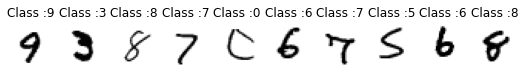

In [10]:
pltsize= 1
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10):
    plt.subplot(1, 11, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [63]:
from torch import dropout


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28,  128)
        self.fc2 = nn.LSTM(input_size=128, hidden_size = 256, dropout = 0.25)
        self.fc3 = nn.GRU(input_size = 256, hidden_size = 512, dropout = 0.25)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x, _ = self.fc2(x)
        x = F.relu(x)
        x, _ = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x)
        return x

In [64]:
del model

In [65]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): LSTM(128, 256, dropout=0.25)
  (fc3): GRU(256, 512, dropout=0.25)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)


In [66]:
def train(model, train_loader, optimizer, log_intervals=100):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0:
            print('Train_Epoch: {}, [{}/{}]({:.0f}%)\tTrain_Loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [67]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad() :
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss = test_loss / len(test_loader)
        test_accruacy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accruacy

In [68]:
best_accruacy = 0
es = 0
for Epoch in range(1, EPOCHS + 1 ):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, \tTest_loss: {:.4f} \tTest_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))


    if test_accuracy > best_accruacy :
        best_accruacy = test_accuracy
        best_model = model
        es = 0
    else :
        es += 1

    if es == 30:
        break

C:\Users\Admin\AppData\Local\Temp\ipykernel_28004\2308905743.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train_Epoch: 1, [0/60000](0%)	Train_Loss : 2.305420
Train_Epoch: 1, [12800/60000](21%)	Train_Loss : 2.296515
Train_Epoch: 1, [25600/60000](43%)	Train_Loss : 2.303245
Train_Epoch: 1, [38400/60000](64%)	Train_Loss : 2.306892
Train_Epoch: 1, [51200/60000](85%)	Train_Loss : 2.302339

EPOCH : 1, 	Test_loss: 0.0292 	Test_accuracy : 11.35%

Train_Epoch: 2, [0/60000](0%)	Train_Loss : 2.296818
Train_Epoch: 2, [12800/60000](21%)	Train_Loss : 2.293420
Train_Epoch: 2, [25600/60000](43%)	Train_Loss : 2.294825
Train_Epoch: 2, [38400/60000](64%)	Train_Loss : 2.300496
Train_Epoch: 2, [51200/60000](85%)	Train_Loss : 2.306930

EPOCH : 2, 	Test_loss: 0.0292 	Test_accuracy : 11.35%

Train_Epoch: 3, [0/60000](0%)	Train_Loss : 2.293535
Train_Epoch: 3, [12800/60000](21%)	Train_Loss : 2.295910
Train_Epoch: 3, [25600/60000](43%)	Train_Loss : 2.300549
Train_Epoch: 3, [38400/60000](64%)	Train_Loss : 2.293785
Train_Epoch: 3, [51200/60000](85%)	Train_Loss : 2.296304

EPOCH : 3, 	Test_loss: 0.0292 	Test_accuracy : 

KeyboardInterrupt: 

In [69]:
print(best_accruacy)

97.14
